# Sky DCGAN

## Setup

In [1]:
# Imports

import sagemaker
import boto3
import argparse
import json
import os
import math
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets
from sagemaker.pytorch import PyTorch

import config
from train.model import DataDiscriminator, DataGenerator
from train.train import get_dataloader, weights_init_normal, train, build_network, fake_loss, real_loss, model_fn, scale


In [2]:
# Directories

imgs_path = '/Volumes/SKYFLASH/fromReddit/' # change to be where you store your training images 
model_dir = '/Volumes/SKYFLASH/sky-gan/' # should be base directory 


In [3]:
# # Sagemaker session

# sagemaker_session = sagemaker.Session(boto3.session.Session(
#     aws_access_key_id=config.aws_access_key_id,
#     aws_secret_access_key=config.aws_secret_access_key,
#     region_name=config.aws_region_name))


# bucket = sagemaker_session.default_bucket()

# prefix = 'sagemaker/dcgan'

# role = 'sagemaker_execution_role'

In [4]:
# Upload training data to S3 bucket 
# input_data = sagemaker_session.upload_data(path=imgs_path, bucket=bucket, key_prefix=prefix)
# input_data = 's3://sagemaker-us-west-1-751070674002/sagemaker/dcgan' # If training data uploaded and this url updated

## Build/train model 

In [5]:
# Model hyperparameters
# Chosen based on https://arxiv.org/pdf/1511.06434.pdf

# img_size = 32
img_size = 64 # if you change this, change model architecture in "model.py" to match 

batch_size = 32 # if you change these parameters, make sure code in "train.py" matches
z_size = 100

conv_dim = 64 

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
epochs = 20

In [6]:
# Load data
train_loader = get_dataloader(batch_size, img_size, imgs_path)


/Users/acavet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


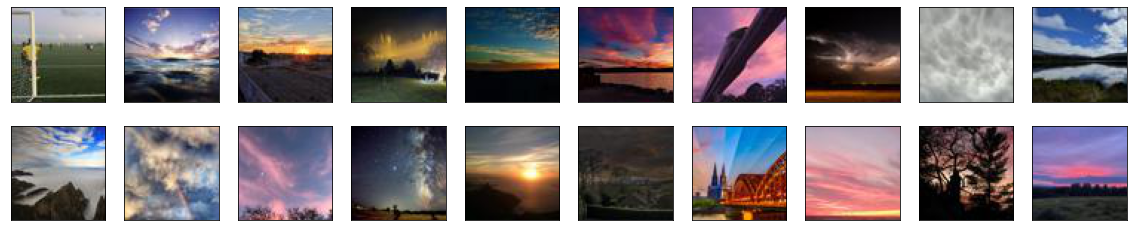

In [7]:
# Helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# One batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot batch images and labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    

In [8]:
# Build and train model on local CPU

device = torch.cuda.is_available()

D, G = build_network(conv_dim, conv_dim, z_size)

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

train(D, G, z_size, train_loader, epochs, d_optimizer, g_optimizer, device)

# Save trained model parameters
G_path = os.path.join(model_dir, 'generator_model.pt')
with open(G_path, 'wb') as f:
    torch.save(G.cpu().state_dict(), f)

DataDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv6): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | Batch [    1/  530] | d_loss: 1.5064 | g_loss: 0.9240
Epoch [    1/   20] | Batch [   51/  530] | d_loss: 0.5893 | g_loss: 2.0115
Epoch [    1/   20] | Batch [  101/  530] | d_loss: 1.7034 | g_loss: 11.2594
Epoch [    1/   20] | Batch [  151/  530] | d_loss: 0.9132 | g_loss: 2.5296
Epoch [    1/   20] | Batch [  201/  530] | d_loss: 0.6480 | g_loss: 2.7185
Epoch [    1/   20] | Batch [  251/  530] | d_loss: 0.9777 | g_loss: 2.7262
Epoch [    1/   20] | Batch [  301/  530] | d_loss: 1.1147 | g_loss: 3.6121
Epoch [    1/   20] | Batch [  351/  530] | d_loss: 1.3672 | g_loss: 1.7844
Epoch [    1/   20] | Batch [  401/  530] | d_loss: 1.7962 | g_loss: 2.8367
Epoch [    1/   20] | Batch [  451/  530] | d_loss: 0.8069 | g_loss: 1.9989
Epoch [    1/   20] | Batch [  501/  530] | d_loss: 1.3825 | g_loss: 3.2249
Epoch [    2/   20] | Batch [    1/  530] | d_loss: 0.9728 | g_loss: 3.8874
Epoch [    2/   20] | Batch [   51/  530] | d_loss: 0.6855 | g_loss: 2.3545
Epoch [    

In [9]:
# # Set up Sagemaker Pytorch model for training 

# estimator = PyTorch(entry_point="train.py",
#                     source_dir="train",
#                     role=role,
#                     py_version="py3",
#                     framework_version='1.5.0',
#                     instance_count=1,
#                     instance_type='ml.m5.4xlarge',
#                     model_dir=model_dir,
#                     hyperparameters={
#                         'epochs': 20,
#                         'conv_dim': 64, # TODO ! orig 64
#                     })

In [10]:
# # Train Sagemaker Pytorch model
# estimator.fit({'training': input_data})


In [11]:
# estimator = estimator.attach('sagemaker-pytorch-2021-07-28-22-01-47-575')

In [12]:
# # Deploy on AWS 
# predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

# # "Deploy" locally on CPU 
model = DataGenerator(z_size=z_size, conv_dim=conv_dim)
model.load_state_dict(torch.load(model_dir+'generator_model.pt'))
# model.load_state_dict(torch.load(model_dir+'20epoch_6464.pt')) # deploy saved model for 64x64 images, 20 epochs
model.cpu() 
model.eval()

DataGenerator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (dconv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

In [21]:
# Helper function to display results
def view_samples(samples):
    
    fig = plt.figure(figsize=(20, 4))
    plot_size=len(samples)
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
        img = samples[idx].detach().cpu().numpy()
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        plt.imshow(np.transpose(img, (1, 2, 0)))


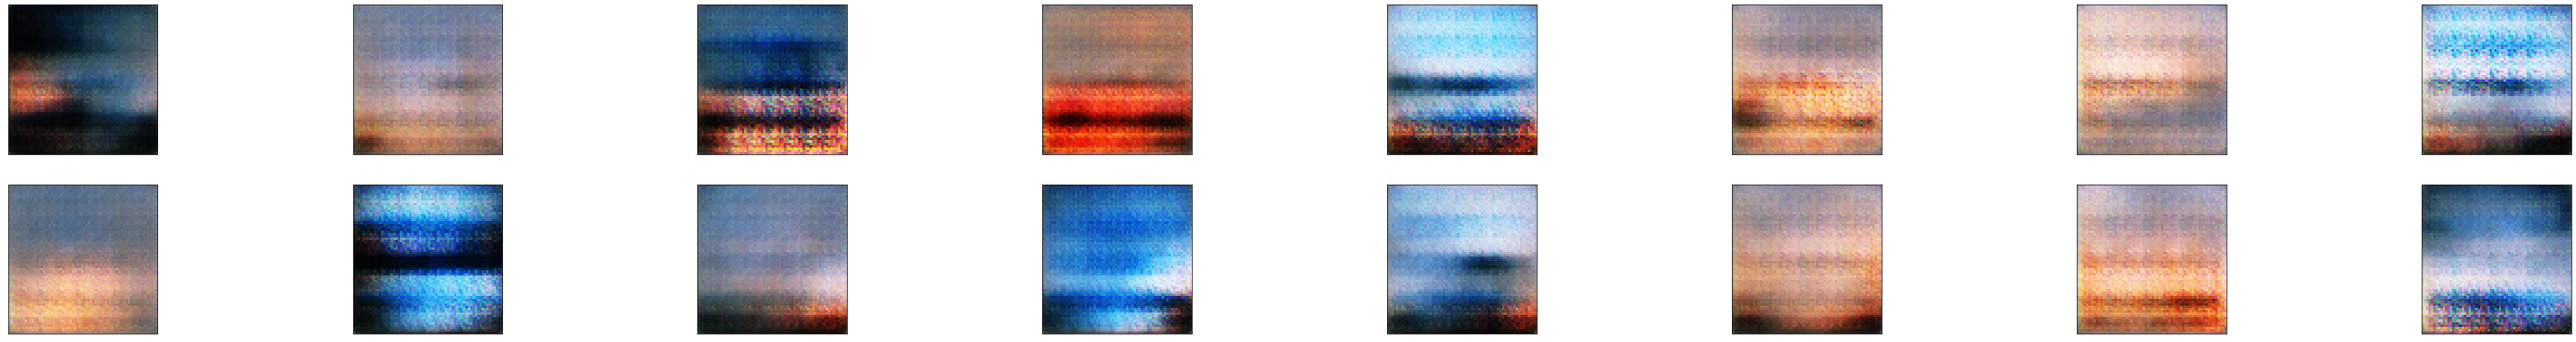

In [15]:
# Show samples taken from final epoch of generator

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)[0]

_ = view_samples(samples)


/Users/acavet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


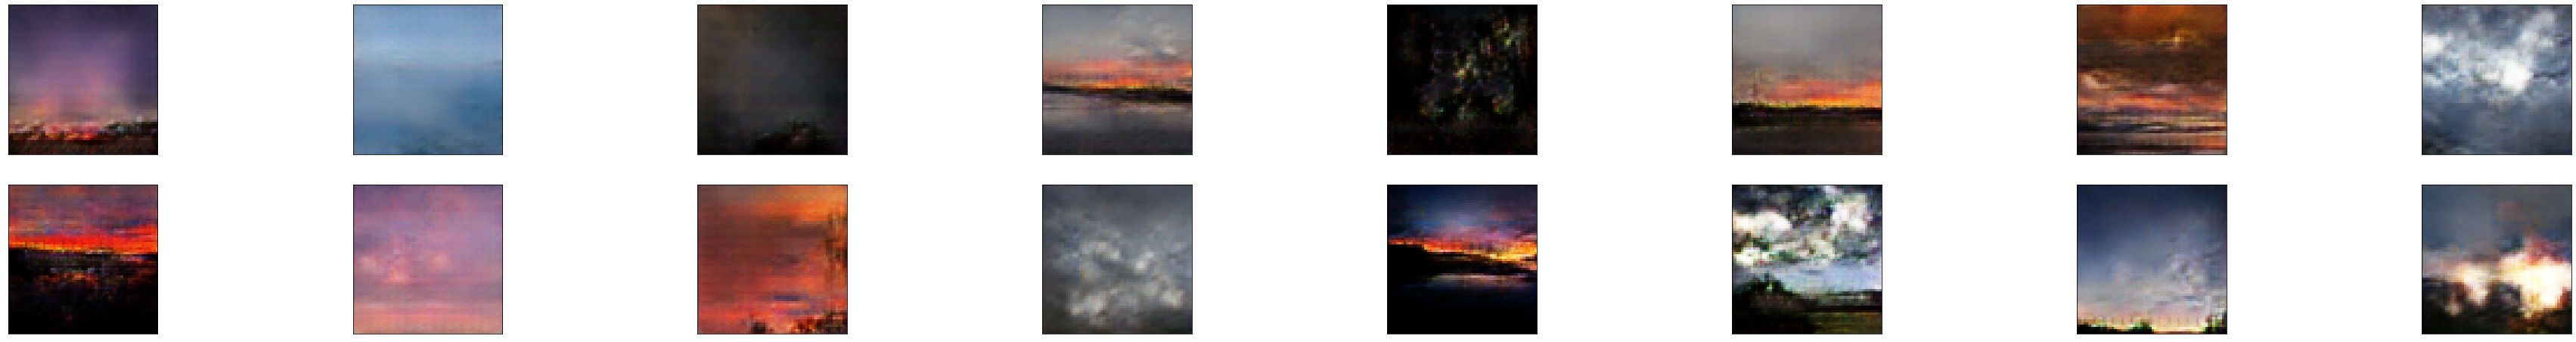

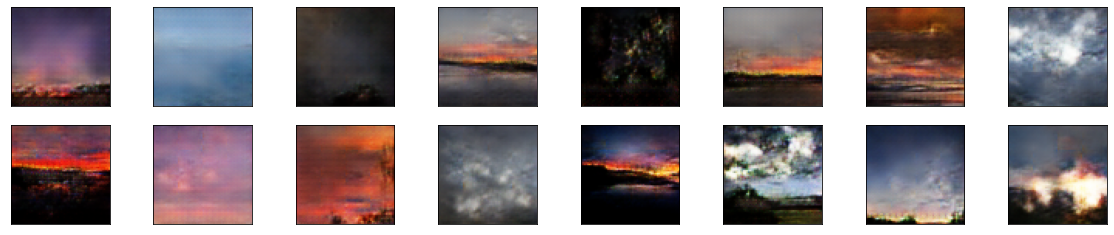

In [22]:
# Generate and display results from noise

z = np.random.uniform(-1, 1, size=(len(samples), 100))
z = torch.from_numpy(z).float().cpu()
imgs_from_noise = model(z)

_ = view_samples(imgs_from_noise)

